# イメージを読みこむ

In [2]:
# !pip install opencv-python

In [1]:
import numpy as np
import os
import glob
import re

import matplotlib.pyplot as plt

import cv2
from PIL import Image

%matplotlib inline

# globを使用

In [2]:
path = './cat_or_dog'
img_list = glob.glob(path + '/*' + '.jpg')
img_list

['./cat_or_dog/dogdesu5.jpg',
 './cat_or_dog/dogdesu4.jpg',
 './cat_or_dog/dogdesu3.jpg',
 './cat_or_dog/dogdesu2.jpg',
 './cat_or_dog/dogdesu1.jpg',
 './cat_or_dog/catdesu2.jpg',
 './cat_or_dog/catdesu3.jpg',
 './cat_or_dog/catdesu4.jpg',
 './cat_or_dog/catdesu5.jpg',
 './cat_or_dog/catdesu.jpg']

In [3]:
cat_img = Image.open(img_list[-1])

(224, 224, 3)


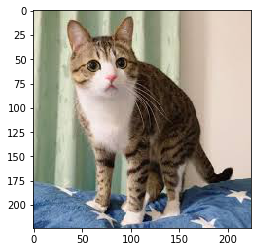

In [4]:
cat_img = cat_img.resize((224, 224))
cat_img = np.array(cat_img)
print(cat_img.shape)
plt.imshow(cat_img)

<class 'numpy.ndarray'>


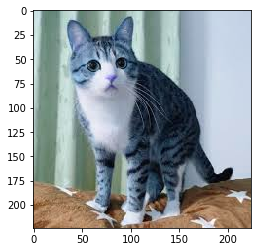

In [5]:
img = cv2.imread(img_list[-1])
img = cv2.resize(img, (224, 224))
print(type(img))
plt.imshow(img)

# イメージのロード、配列化、リサイズ、データセット作成

In [6]:
dog_img_array = np.empty((0, 224, 224, 3))
cat_img_array = np.empty((0, 224, 224, 3))

for img in img_list:
    if re.search('dogdesu', img):
        dog_img = Image.open(img)
        
        dog_img = dog_img.resize((224, 224))
        
        dog_img = np.array(dog_img)
        
        dog_img = dog_img / 255.0
        
        dog_img = dog_img.reshape((1, 224, 224, 3))
        
        dog_img_array = np.concatenate([dog_img_array, dog_img],
                                      axis=0)
        
    if re.search('catdesu', img):
        
        cat_img = Image.open(img)
        
        cat_img = cat_img.resize((224, 224))
        
        cat_img = np.array(cat_img)
        print(cat_img.shape)
        
        cat_img = cat_img / 255.0
        
        cat_img = cat_img.reshape((1, 224, 224, 3))
        
        cat_img_array = np.concatenate([cat_img_array, cat_img],
                                      axis=0)
        
        

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [7]:
print(dog_img_array.shape)
print(cat_img_array.shape)

(5, 224, 224, 3)
(5, 224, 224, 3)


# イメージの表示

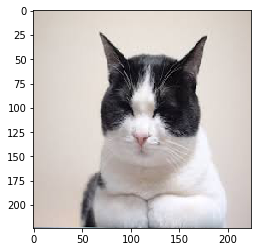

In [8]:
plt.imshow(cat_img_array[0])

In [9]:
'''
画像の中心を切り出し
'''

def crop_center(pil_img, crop_width, crop_height):
    
    img_width, img_height = pil_img.size
    
    print('img_width - crop_width', img_width - crop_width)
    print('img_width + crop_width', img_width + crop_width)
    return pil_img.crop(((img_width - crop_width) //2, 
                        (img_height - crop_height) //2 ,
                        (img_width + crop_width)//2, 
                        (img_height + crop_height)//2))
    

<class 'PIL.JpegImagePlugin.JpegImageFile'>
img_width - crop_width 176
img_width + crop_width 624


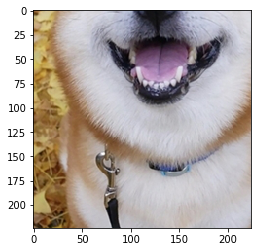

In [10]:
img = Image.open(img_list[0])
print(type(img))
img_new = crop_center(img, 224, 224)
plt.imshow(img_new)

# openCVの色形式

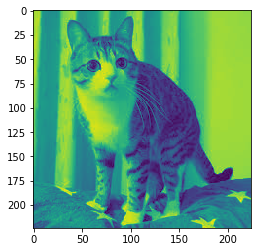

In [11]:
img = cv2.imread(img_list[-1], 0)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

# BGRとRGB

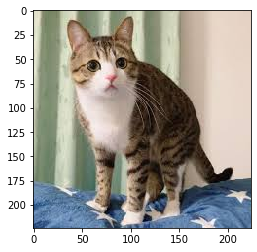

In [12]:
img = cv2.imread(img_list[-1])
img = cv2.resize(img, (224, 224))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)


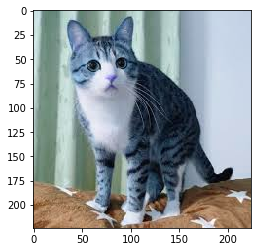

In [13]:
plt.imshow(img)

In [14]:
!pip search albumentations

albumentations (0.4.3)   - Fast image augmentation library and easy
                           to use wrapper around other libraries
  INSTALLED: 0.4.3 (latest)
audiomentations (0.7.0)  - A Python library for audio data
                           augmentation. Inspired by albumentations.
                           Useful for machine learning.


In [15]:
!pip install albumentations

# albumentationによってデータを拡張する

In [16]:
from urllib.request import urlopen

In [17]:
def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(5, 5))
    plt.imshow(image)

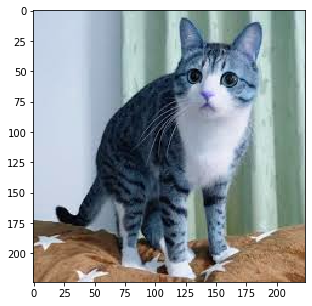

In [18]:
from albumentations import HorizontalFlip
#水平線方向に反転
aug = HorizontalFlip(p=1)
augment_and_show(aug, img)

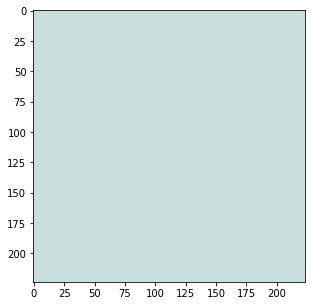

In [19]:
from albumentations import IAAPerspective
aug = IAAPerspective(scale=0.2, p=1)
augment_and_show(aug, img)

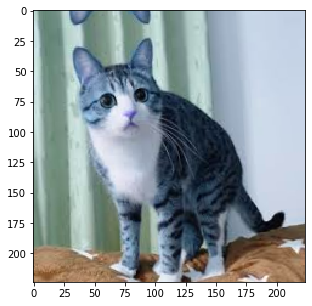

In [20]:
from albumentations import ShiftScaleRotate
aug = ShiftScaleRotate(p=0.6)
augment_and_show(aug, img)

In [21]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)
def augment_flips_color(p=.5):
    return Compose([
    CLAHE(),
    RandomRotate90(),
        Transpose(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50,
                        rotate_limit=45, p=.75),
        Blur(blur_limit=3),
        OpticalDistortion(),
        GridDistortion(),
        HueSaturationValue()
    ], p=p)

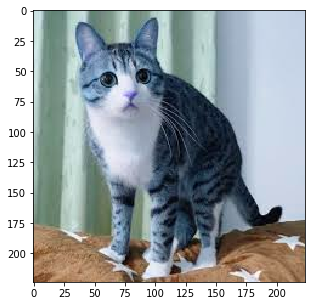

In [22]:
aug = augment_flips_color(p=0.5)
augment_and_show(aug, img)

# 問題1 自作データセットでの分類の学習および問題2 分類データセットに対するデータ拡張

# ImageDataGeneratorによってデータを拡張する

In [23]:
import keras

Using TensorFlow backend.


In [24]:
X_train = np.concatenate([dog_img_array, cat_img_array], axis=0)
print(X_train.shape)
y_train = np.concatenate([np.zeros((5)), np.ones((5))])
print(y_train.shape)

(10, 224, 224, 3)
(10,)


In [26]:
def one_hot(y):
    N = len(y)
    D = len(np.unique(y))
    one_hot = np.zeros((N,D))
    for idx, val in enumerate(np.unique(y)):
        mask = y == val
        one_hot[mask, idx] = 1
    return one_hot
    

In [27]:
y_train_onehot = one_hot(y_train)
print(y_train_onehot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [28]:
import keras.preprocessing.image as Image
datagen = Image.ImageDataGenerator(
rotation_range=30,
width_shift_range=0.3,
height_shift_range=0.3,
horizontal_flip=True,
validation_split=0.2)


In [29]:
# train_generator = datagen.flow_from_directory(
# path,
# target_size=(224, 224),
# batch_size=2,
# shuffle=True,
# subset='training')

In [30]:
datagen.fit(X_train)

In [31]:
train_generator= datagen.flow(X_train, y_train_onehot,
                             batch_size=32, shuffle=True)

# 転移学習

In [32]:
#まずモデルを生成して、fit_generatormを試してみる

In [33]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam,SGD
from keras.callbacks import CSVLogger

n_categories = 2
batch_size = 32

base_model = VGG16(weights='imagenet', include_top=False,
                  input_tensor = Input(shape=(224, 224, 3)))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
prediction = Dense(n_categories, activation='softmax')(x)
model = Model(inputs=base_model.input, output=prediction)

W0120 19:35:42.165992 4469937600 deprecation_wrapper.py:119] From //anaconda3/envs/aistudio/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0120 19:35:42.224151 4469937600 deprecation_wrapper.py:119] From //anaconda3/envs/aistudio/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0120 19:35:42.251650 4469937600 deprecation_wrapper.py:119] From //anaconda3/envs/aistudio/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0120 19:35:42.341893 4469937600 deprecation_wrapper.py:119] From //anaconda3/envs/aistudio/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0120 19:35:42.

In [34]:
for layer in base_model.layers[:15]:
    layer.trainable = False

In [35]:
model.compile(optimizer=SGD(lr=0.001, momentum=0.9),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
model.summary()

W0120 19:35:48.594426 4469937600 deprecation_wrapper.py:119] From //anaconda3/envs/aistudio/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [36]:
hist = model.fit_generator(
    train_generator,
    epochs=10,
    steps_per_epoch=10,
    verbose=1,
    callbacks=[CSVLogger('vgg16_for_dog_or_cat.csv')]
)

W0120 19:35:52.294018 4469937600 deprecation.py:323] From //anaconda3/envs/aistudio/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
10/10 [==============================] - 43s 4s/step - loss: 0.6843 - acc: 0.5300
Epoch 2/10
10/10 [==============================] - 48s 5s/step - loss: 0.5441 - acc: 0.9100
Epoch 3/10
10/10 [==============================] - 48s 5s/step - loss: 0.3709 - acc: 1.0000
Epoch 4/10
10/10 [==============================] - 49s 5s/step - loss: 0.2199 - acc: 0.9900
Epoch 5/10
10/10 [==============================] - 45s 5s/step - loss: 0.1089 - acc: 0.9900
Epoch 6/10
10/10 [==============================] - 44s 4s/step - loss: 0.0618 - acc: 1.0000
Epoch 7/10
10/10 [==============================] - 39s 4s/step - loss: 0.0277 - acc: 1.0000
Epoch 8/10
10/10 [==============================] - 42s 4s/step - loss: 0.0170 - acc: 1.0000
Epoch 9/10
10/10 [==============================] - 40s 4s/step - loss: 0.0158 - acc: 1.0000
Epoch 10/10
10/10 [==============================] - 39s 4s/step - loss: 0.0100 - acc: 1.0000


In [37]:
model.save('vgg16_for_dog_or_cat.h5')

In [38]:
model_path = 'vgg16_for_dog_or_cat.json'
json_string = model.to_json()
with open(model_path, mode='w') as f:
    f.write(json_string)

# テスト画像でモデルを評価する

In [39]:
test_path = './test_cat_or_dog'
test_img_list = glob.glob(test_path + '/*.jpg')
test_img_list

['./test_cat_or_dog/inudesu4.jpg',
 './test_cat_or_dog/inudesu1.jpg',
 './test_cat_or_dog/inudesu2.jpg',
 './test_cat_or_dog/inudesu3.jpg',
 './test_cat_or_dog/nekodesu1.jpg',
 './test_cat_or_dog/nekodesu2.jpg',
 './test_cat_or_dog/nekodesu3.jpg',
 './test_cat_or_dog/nekodesu4.jpg']

In [40]:
from PIL import Image
# neko = bytes(b'neko')
# inu = bytes(b'inu')

test_dog_img_array = np.empty((0,224,224,3))
test_cat_img_array = np.empty((0,224,224,3))
for img in test_img_list:
    print(type(img))
    if re.search('inu',img):
        dog_img = Image.open(img)
        dog_img = dog_img.resize((224,224))
        dog_img = np.array(dog_img)
        dog_img = dog_img / 255.0
        dog_img = dog_img.reshape(1,224,224,3)
        test_dog_img_array = np.concatenate([test_dog_img_array,
                                            dog_img],axis=0)
        
    if re.search('neko', img):
        cat_img = Image.open(img)
        cat_img = cat_img.resize((224,224))
        cat_img = np.array(cat_img)
        cat_img = cat_img / 255.0
        cat_img = cat_img.reshape(1,224,224,3)
        test_cat_img_array = np.concatenate([test_cat_img_array,
                                            cat_img],axis=0)
        
        

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


(224, 224, 3)


NameError: name 'label' is not defined

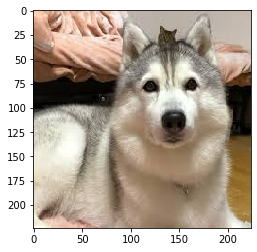

In [45]:
print(test_dog_img_array[3].shape)
plt.imshow(test_dog_img_array[3])
print(label[np.argmax(model.predict(test_dog_img_array[4].reshape(1,224,224,3)))])

In [ ]:
X_test = np.concatenate([test_dog_img_array, test_cat_img_array],
                       axis=0)
y_test = np.concatenate([np.zeros((4)), np.ones((4))])
y_test_onehot = one_hot(y_test)

print(y_test_onehot)



In [ ]:
print(y_train)

In [ ]:
model.predict(X_train[6].reshape(1,224,224,3))

In [ ]:
from keras.models import model_from_json
label = ['dog', 'cat']
# model.load_weights('vgg16_for_dog_or_cat.h5')
# json_string = open(model_path).read()
# model = model_from_json(json_string)
test_preds = model.predict(X_test)
plt.figure(1, figsize=(10,5))
plt.subplots_adjust(wspace=0.4,hspace=0.4)
for i in range(8):
    img = X_test[i]
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title(label[np.argmax(test_preds[i])])



In [ ]:
test_preds

In [ ]:
plt.plot(hist.history['loss'])

# 問題3 物体検出データセットの用意

In [1]:
%matplotlib inline
from urllib.request import urlopen
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
def download_image(url):
    data = open(url,"rb").read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [4]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(w), int(y_min), int(h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(10,40))
    plt.imshow(img)
    return img

def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='coco', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))

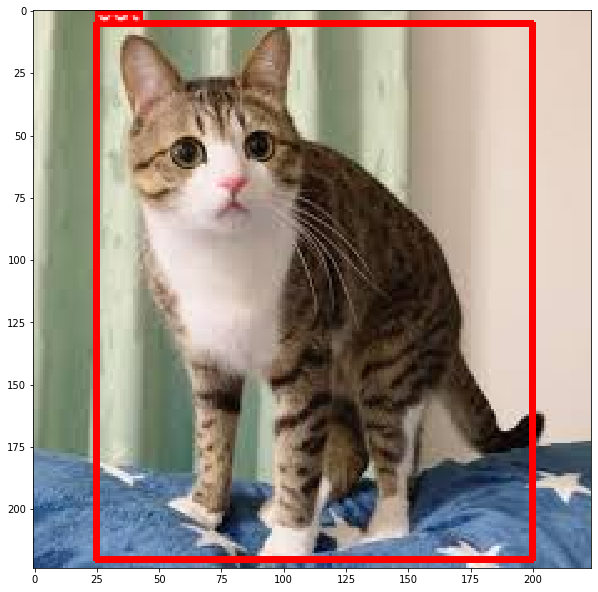

In [21]:
from PIL import Image
image = download_image('./cat_or_dog/catdesu.jpg')
image = np.array(image)


annotations = {'image': image, 'bboxes': [[25,5,200,220]], 'category_id': [0]}
category_id_to_name = {0: 'cat', 1: 'dog'}
img = visualize(annotations, category_id_to_name)

pillow = Image.fromarray(np.uint8(img))
pillow.save("./ano_data/catdesu.jpg")

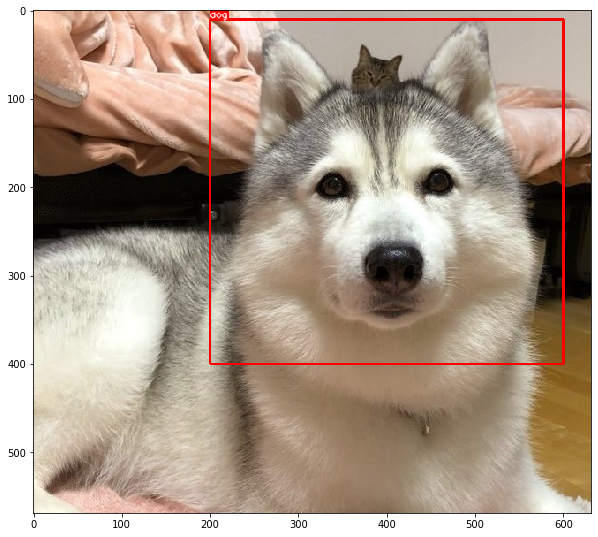

In [26]:
from PIL import Image
image = download_image('./cat_or_dog/dogdesu1.jpg')
image = np.array(image)


annotations = {'image': image, 'bboxes': [[200,10,600,400]], 'category_id': [1]}
category_id_to_name = {0: 'cat', 1: 'dog'}
img = visualize(annotations, category_id_to_name)

pillow = Image.fromarray(np.uint8(img))
pillow.save("./ano_data/dogdesu1.jpg")

# 問題4 物体検出データセットに対するデータ拡張

In [38]:
# 入力ディレクトリを作成

from keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
import glob
input_dir = "./ano_data/cat"
files = glob.glob(input_dir + '/*.jp*g')
 
# 出力ディレクトリを作成
output_dir = "./ano_argumentation/"
if os.path.isdir(output_dir) == False:
    os.mkdir(output_dir)
 
 
for i, file in enumerate(files):
 
    img = load_img(file)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
 
    # ImageDataGeneratorの生成
    datagen = ImageDataGenerator(
            rescale=None,
            rotation_range=45,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.3,
            zoom_range=0.3,
            channel_shift_range=5.,
            horizontal_flip=True,
            )
 
    # 9個の画像を生成します
    g = datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix='cat', save_format='jpg')
    for i in range(51):
        batch = g.next()

./ano_argumentation/cat_0_753.jpg


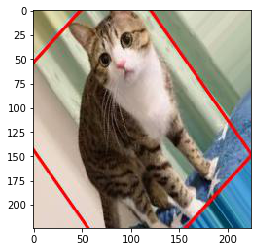

./ano_argumentation/cat_0_6805.jpg


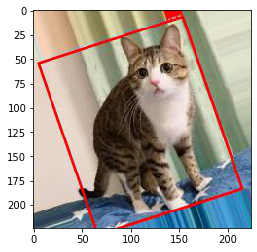

./ano_argumentation/cat_0_397.jpg


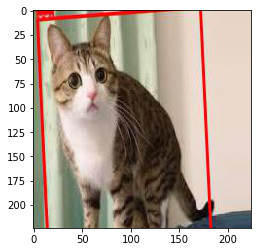

./ano_argumentation/cat_0_7460.jpg


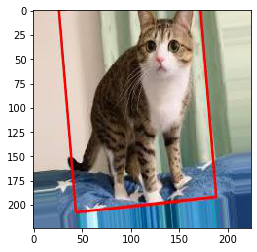

./ano_argumentation/cat_0_3834.jpg


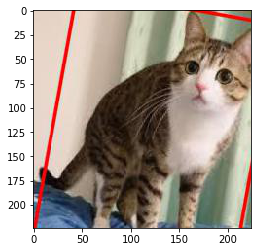

./ano_argumentation/cat_0_8949.jpg


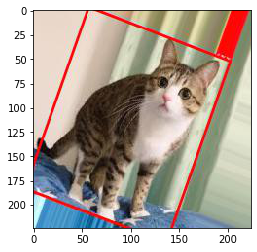

In [41]:
from PIL import Image

img_num = 0
for img_path in glob.glob('./ano_argumentation/*.jpg'):
    print(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    img_num += 1
    if img_num > 5:
        break
    